Library

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
# Import metrics baru
from tensorflow.keras.metrics import AUC, Precision, Recall, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2 # Contoh model pre-trained

# Pastikan BASE_DIR_DATASET sudah didefinisikan dari skrip preprocessing atau definisikan ulang
# Asumsi notebook berada di 'notebooks/' dan dataset di 'dataset/'
import os
import numpy as np # Pastikan numpy diimpor
from sklearn.model_selection import train_test_split # Pastikan train_test_split diimpor
import matplotlib.pyplot as plt # Pastikan matplotlib diimpor

BASE_DIR_DATASET = os.path.abspath(os.path.join(os.getcwd(), '..', 'dataset'))
IMG_SIZE = (224, 224) # Ukuran gambar target untuk model CNN
# Ini adalah definisi LABELS_FINAL yang sama seperti di skrip pembuatan dataset dan preprocessing
LABELS_FINAL = ['battery', 'organik', 'glass', 'cardboard', 'metal', 'paper', 'plastic', 'trash']

Load Data

In [2]:
print("\n--- 7. Memuat Data yang Sudah Diproses (NumPy Arrays) ---")
try:
    X = np.load(os.path.join(BASE_DIR_DATASET, 'X_data.npy'))
    Y = np.load(os.path.join(BASE_DIR_DATASET, 'Y_labels.npy'))
    print(f"Data X.npy dimuat dengan bentuk: {X.shape}")
    print(f"Data Y.npy dimuat dengan bentuk: {Y.shape}")
except FileNotFoundError:
    print(f"Error: File X_data.npy atau Y_labels.npy tidak ditemukan di {BASE_DIR_DATASET}.")
    print("Pastikan Anda sudah menjalankan bagian Preprocessing dan konversi NumPy array.")
    exit()


--- 7. Memuat Data yang Sudah Diproses (NumPy Arrays) ---
Data X.npy dimuat dengan bentuk: (4992, 224, 224, 3)
Data Y.npy dimuat dengan bentuk: (4992, 8)


Split Data Train/Validation/Test

In [3]:
print("\n--- 8. Membagi Data menjadi Train, Validation, dan Test Set ---")
# Split awal untuk train + val vs test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.15, random_state=42, shuffle=True) # 15% untuk test
# Split train_val menjadi train dan val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, shuffle=True) # 20% dari sisanya untuk validasi

print(f"Bentuk data pelatihan (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Bentuk data validasi (X_val, y_val): {X_val.shape}, {y_val.shape}")
print(f"Bentuk data uji (X_test, y_test): {X_test.shape}, {y_test.shape}")



--- 8. Membagi Data menjadi Train, Validation, dan Test Set ---
Bentuk data pelatihan (X_train, y_train): (3394, 224, 224, 3), (3394, 8)
Bentuk data validasi (X_val, y_val): (849, 224, 224, 3), (849, 8)
Bentuk data uji (X_test, y_test): (749, 224, 224, 3), (749, 8)


Arsitektur Model

In [4]:
print("\n--- 9. Mendefinisikan Arsitektur Model ---")

# Opsi 1: Model CNN Kustom Anda (dengan penambahan BatchNormalization & Augmentasi)
def build_custom_cnn_model(input_shape, num_classes):
    model = Sequential([
        # Augmentasi Data (On-the-fly) - Ditempatkan di awal model
        # Ini adalah cara yang efisien untuk augmentasi pada GPU
        tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
        tf.keras.layers.RandomRotation(0.1), # Rotasi +- 10% dari 360 derajat
        tf.keras.layers.RandomZoom(0.1),    # Zoom in/out +- 10%

        Conv2D(32, (3,3), activation='relu'), # input_shape tidak perlu lagi di sini karena sudah di RandomFlip
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='sigmoid') # sigmoid untuk multi-label
    ])
    return model

# Opsi 2: Menggunakan Model Pre-trained (Contoh: MobileNetV2)
def build_transfer_learning_model(input_shape, num_classes, include_augmentation=True):
    # Base model pre-trained
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False # Bekukan base model awalnya

    inputs = Input(shape=input_shape)
    
    # Tambahkan lapisan augmentasi di sini jika diinginkan
    if include_augmentation:
        x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(inputs)
        x = tf.keras.layers.RandomRotation(0.1)(x)
        x = tf.keras.layers.RandomZoom(0.1)(x)
    else:
        x = inputs

    x = base_model(x, training=False) # Pastikan base model berjalan dalam inference mode saat dibekukan
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

# Pilih model yang akan digunakan
# Jika ingin menggunakan augmentasi pada custom CNN:
# model = build_custom_cnn_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(LABELS_FINAL))

# Jika ingin menggunakan MobileNetV2 dengan augmentasi:
model = build_transfer_learning_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=len(LABELS_FINAL), include_augmentation=True)

model.summary()


--- 9. Mendefinisikan Arsitektur Model ---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Compile Model

In [5]:
# --- 10. Kompilasi Model ---
print("\n--- 10. Mengompilasi Model ---")
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[
                  BinaryAccuracy(name='binary_accuracy'), # Lebih tepat dari 'accuracy' biasa
                  Precision(name='precision'),
                  Recall(name='recall'),
                  AUC(name='auc') # Area Under the ROC Curve
              ])


--- 10. Mengompilasi Model ---


Callback

In [6]:
# --- 11. Callbacks ---
print("\n--- 11. Mengatur Callbacks ---")
checkpoint_dir = os.path.join(BASE_DIR_DATASET, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'best_model.h5')

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', mode='min'),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
]
print(f"Model terbaik akan disimpan di: {checkpoint_path}")



--- 11. Mengatur Callbacks ---
Model terbaik akan disimpan di: d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


Training Model

In [7]:
print("\n--- 12. Memulai Pelatihan Model ---")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)


--- 12. Memulai Pelatihan Model ---
Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - auc: 0.4821 - binary_accuracy: 0.5118 - loss: 0.8991 - precision: 0.3611 - recall: 0.3805
Epoch 1: val_loss improved from inf to 0.72066, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 812ms/step - auc: 0.4822 - binary_accuracy: 0.5120 - loss: 0.8987 - precision: 0.3612 - recall: 0.3801 - val_auc: 0.5135 - val_binary_accuracy: 0.5649 - val_loss: 0.7207 - val_precision: 0.3973 - val_recall: 0.3002
Epoch 2/50
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - auc: 0.5212 - binary_accuracy: 0.5645 - loss: 0.8131 - precision: 0.4023 - recall: 0.3273
Epoch 2: val_loss improved from 0.72066 to 0.68482, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 79s 738ms/step - auc: 0.5212 - binary_accuracy: 0.5645 - loss: 0.8130 - precision: 0.4023 - recall: 0.3274 - val_auc: 0.5627 - val_binary_accuracy: 0.6011 - val_loss: 0.6848 - val_precision: 0.4500 - val_recall: 0.2654
Epoch 3/50
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - auc: 0.5521 - binary_accuracy: 0.5825 - loss: 0.7762 - precision: 0.4302 - recall: 0.3424
Epoch 3: val_loss improved from 0.68482 to 0.65902, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 709ms/step - auc: 0.5521 - binary_accuracy: 0.5825 - loss: 0.7761 - precision: 0.4302 - recall: 0.3424 - val_auc: 0.6055 - val_binary_accuracy: 0.6232 - val_loss: 0.6590 - val_precision: 0.4997 - val_recall: 0.2858
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - auc: 0.5717 - binary_accuracy: 0.5926 - loss: 0.7500 - precision: 0.4462 - recall: 0.3591
Epoch 4: val_loss improved from 0.65902 to 0.64033, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 731ms/step - auc: 0.5718 - binary_accuracy: 0.5926 - loss: 0.7500 - precision: 0.4462 - recall: 0.3592 - val_auc: 0.6387 - val_binary_accuracy: 0.6418 - val_loss: 0.6403 - val_precision: 0.5459 - val_recall: 0.2909
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - auc: 0.5897 - binary_accuracy: 0.6034 - loss: 0.7320 - precision: 0.4610 - recall: 0.3748
Epoch 5: val_loss improved from 0.64033 to 0.62239, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 75s 702ms/step - auc: 0.5898 - binary_accuracy: 0.6035 - loss: 0.7319 - precision: 0.4611 - recall: 0.3749 - val_auc: 0.6679 - val_binary_accuracy: 0.6587 - val_loss: 0.6224 - val_precision: 0.5898 - val_recall: 0.3081
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - auc: 0.6029 - binary_accuracy: 0.6129 - loss: 0.7204 - precision: 0.4841 - recall: 0.3909
Epoch 6: val_loss improved from 0.62239 to 0.61168, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 77s 722ms/step - auc: 0.6030 - binary_accuracy: 0.6129 - loss: 0.7204 - precision: 0.4840 - recall: 0.3909 - val_auc: 0.6876 - val_binary_accuracy: 0.6693 - val_loss: 0.6117 - val_precision: 0.6272 - val_recall: 0.3006
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - auc: 0.6122 - binary_accuracy: 0.6141 - loss: 0.7089 - precision: 0.4821 - recall: 0.3916
Epoch 7: val_loss improved from 0.61168 to 0.60438, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 711ms/step - auc: 0.6123 - binary_accuracy: 0.6142 - loss: 0.7088 - precision: 0.4822 - recall: 0.3918 - val_auc: 0.7014 - val_binary_accuracy: 0.6799 - val_loss: 0.6044 - val_precision: 0.6624 - val_recall: 0.3061
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - auc: 0.6400 - binary_accuracy: 0.6344 - loss: 0.6815 - precision: 0.5132 - recall: 0.4078
Epoch 8: val_loss improved from 0.60438 to 0.59514, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 75s 705ms/step - auc: 0.6400 - binary_accuracy: 0.6344 - loss: 0.6815 - precision: 0.5132 - recall: 0.4078 - val_auc: 0.7132 - val_binary_accuracy: 0.6862 - val_loss: 0.5951 - val_precision: 0.6644 - val_recall: 0.3374
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - auc: 0.6549 - binary_accuracy: 0.6418 - loss: 0.6690 - precision: 0.5300 - recall: 0.4362
Epoch 9: val_loss improved from 0.59514 to 0.58781, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 75s 703ms/step - auc: 0.6549 - binary_accuracy: 0.6418 - loss: 0.6690 - precision: 0.5300 - recall: 0.4362 - val_auc: 0.7247 - val_binary_accuracy: 0.6911 - val_loss: 0.5878 - val_precision: 0.6783 - val_recall: 0.3421
Epoch 10/50
106/107 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - auc: 0.6540 - binary_accuracy: 0.6357 - loss: 0.6711 - precision: 0.5203 - recall: 0.4330
Epoch 10: val_loss improved from 0.58781 to 0.58414, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 733ms/step - auc: 0.6541 - binary_accuracy: 0.6358 - loss: 0.6710 - precision: 0.5204 - recall: 0.4330 - val_auc: 0.7300 - val_binary_accuracy: 0.6952 - val_loss: 0.5841 - val_precision: 0.6846 - val_recall: 0.3538
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - auc: 0.6577 - binary_accuracy: 0.6422 - loss: 0.6685 - precision: 0.5316 - recall: 0.4389
Epoch 11: val_loss improved from 0.58414 to 0.57533, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 77s 722ms/step - auc: 0.6577 - binary_accuracy: 0.6423 - loss: 0.6684 - precision: 0.5317 - recall: 0.4389 - val_auc: 0.7408 - val_binary_accuracy: 0.7011 - val_loss: 0.5753 - val_precision: 0.6973 - val_recall: 0.3647
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - auc: 0.6734 - binary_accuracy: 0.6507 - loss: 0.6493 - precision: 0.5417 - recall: 0.4525
Epoch 12: val_loss improved from 0.57533 to 0.57497, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 77s 716ms/step - auc: 0.6734 - binary_accuracy: 0.6507 - loss: 0.6493 - precision: 0.5418 - recall: 0.4525 - val_auc: 0.7427 - val_binary_accuracy: 0.7010 - val_loss: 0.5750 - val_precision: 0.7041 - val_recall: 0.3554
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - auc: 0.6815 - binary_accuracy: 0.6564 - loss: 0.6441 - precision: 0.5577 - recall: 0.4594
Epoch 13: val_loss improved from 0.57497 to 0.56737, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 746ms/step - auc: 0.6815 - binary_accuracy: 0.6565 - loss: 0.6441 - precision: 0.5577 - recall: 0.4594 - val_auc: 0.7529 - val_binary_accuracy: 0.7052 - val_loss: 0.5674 - val_precision: 0.7125 - val_recall: 0.3643
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - auc: 0.6871 - binary_accuracy: 0.6620 - loss: 0.6350 - precision: 0.5603 - recall: 0.4573
Epoch 14: val_loss improved from 0.56737 to 0.56473, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 705ms/step - auc: 0.6871 - binary_accuracy: 0.6619 - loss: 0.6350 - precision: 0.5603 - recall: 0.4573 - val_auc: 0.7563 - val_binary_accuracy: 0.7066 - val_loss: 0.5647 - val_precision: 0.7175 - val_recall: 0.3643
Epoch 15/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - auc: 0.7021 - binary_accuracy: 0.6740 - loss: 0.6191 - precision: 0.5765 - recall: 0.4689
Epoch 15: val_loss improved from 0.56473 to 0.56010, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 749ms/step - auc: 0.7021 - binary_accuracy: 0.6739 - loss: 0.6191 - precision: 0.5765 - recall: 0.4688 - val_auc: 0.7601 - val_binary_accuracy: 0.7110 - val_loss: 0.5601 - val_precision: 0.7127 - val_recall: 0.3898
Epoch 16/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - auc: 0.6984 - binary_accuracy: 0.6675 - loss: 0.6246 - precision: 0.5703 - recall: 0.4806
Epoch 16: val_loss improved from 0.56010 to 0.55721, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 74s 691ms/step - auc: 0.6984 - binary_accuracy: 0.6675 - loss: 0.6246 - precision: 0.5704 - recall: 0.4805 - val_auc: 0.7652 - val_binary_accuracy: 0.7128 - val_loss: 0.5572 - val_precision: 0.7227 - val_recall: 0.3851
Epoch 17/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - auc: 0.7041 - binary_accuracy: 0.6721 - loss: 0.6180 - precision: 0.5754 - recall: 0.4812
Epoch 17: val_loss did not improve from 0.55721
107/107 ━━━━━━━━━━━━━━━━━━━━ 72s 674ms/step - auc: 0.7042 - binary_accuracy: 0.6721 - loss: 0.6179 - precision: 0.5755 - recall: 0.4812 - val_auc: 0.7640 - val_binary_accuracy: 0.7145 - val_loss: 0.5577 - val_precision: 0.7261 - val_recall: 0.3886
Epoch 18/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - auc: 0.7112 - binary_accuracy: 0.6777 - loss: 0.6109 - precision: 0.5880 - recall: 0.4791
Epoch 18: val_loss improved from 0.55721 to 0.55621, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 680ms/step - auc: 0.7112 - binary_accuracy: 0.6777 - loss: 0.6109 - precision: 0.5880 - recall: 0.4791 - val_auc: 0.7674 - val_binary_accuracy: 0.7166 - val_loss: 0.5562 - val_precision: 0.7336 - val_recall: 0.3886
Epoch 19/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - auc: 0.7229 - binary_accuracy: 0.6844 - loss: 0.5991 - precision: 0.5975 - recall: 0.4892
Epoch 19: val_loss improved from 0.55621 to 0.55108, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 70s 658ms/step - auc: 0.7229 - binary_accuracy: 0.6844 - loss: 0.5991 - precision: 0.5975 - recall: 0.4892 - val_auc: 0.7706 - val_binary_accuracy: 0.7203 - val_loss: 0.5511 - val_precision: 0.7288 - val_recall: 0.4097
Epoch 20/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - auc: 0.7217 - binary_accuracy: 0.6868 - loss: 0.5983 - precision: 0.5951 - recall: 0.4959
Epoch 20: val_loss improved from 0.55108 to 0.54892, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 71s 661ms/step - auc: 0.7217 - binary_accuracy: 0.6868 - loss: 0.5983 - precision: 0.5951 - recall: 0.4959 - val_auc: 0.7735 - val_binary_accuracy: 0.7179 - val_loss: 0.5489 - val_precision: 0.7267 - val_recall: 0.4023
Epoch 21/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - auc: 0.7135 - binary_accuracy: 0.6763 - loss: 0.6091 - precision: 0.5863 - recall: 0.4755
Epoch 21: val_loss improved from 0.54892 to 0.54710, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 711ms/step - auc: 0.7135 - binary_accuracy: 0.6763 - loss: 0.6090 - precision: 0.5864 - recall: 0.4756 - val_auc: 0.7751 - val_binary_accuracy: 0.7195 - val_loss: 0.5471 - val_precision: 0.7272 - val_recall: 0.4085
Epoch 22/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - auc: 0.7260 - binary_accuracy: 0.6874 - loss: 0.5949 - precision: 0.6031 - recall: 0.4910
Epoch 22: val_loss improved from 0.54710 to 0.54552, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 74s 688ms/step - auc: 0.7260 - binary_accuracy: 0.6875 - loss: 0.5949 - precision: 0.6031 - recall: 0.4910 - val_auc: 0.7786 - val_binary_accuracy: 0.7241 - val_loss: 0.5455 - val_precision: 0.7415 - val_recall: 0.4105
Epoch 23/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - auc: 0.7346 - binary_accuracy: 0.6965 - loss: 0.5873 - precision: 0.6196 - recall: 0.4993
Epoch 23: val_loss improved from 0.54552 to 0.54351, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 679ms/step - auc: 0.7346 - binary_accuracy: 0.6965 - loss: 0.5874 - precision: 0.6195 - recall: 0.4993 - val_auc: 0.7804 - val_binary_accuracy: 0.7247 - val_loss: 0.5435 - val_precision: 0.7416 - val_recall: 0.4128
Epoch 24/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - auc: 0.7337 - binary_accuracy: 0.6940 - loss: 0.5860 - precision: 0.6138 - recall: 0.5038
Epoch 24: val_loss improved from 0.54351 to 0.54188, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 734ms/step - auc: 0.7337 - binary_accuracy: 0.6940 - loss: 0.5860 - precision: 0.6138 - recall: 0.5038 - val_auc: 0.7820 - val_binary_accuracy: 0.7222 - val_loss: 0.5419 - val_precision: 0.7385 - val_recall: 0.4062
Epoch 25/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - auc: 0.7324 - binary_accuracy: 0.6921 - loss: 0.5859 - precision: 0.6099 - recall: 0.4988
Epoch 25: val_loss improved from 0.54188 to 0.54141, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 77s 720ms/step - auc: 0.7325 - binary_accuracy: 0.6921 - loss: 0.5859 - precision: 0.6099 - recall: 0.4988 - val_auc: 0.7825 - val_binary_accuracy: 0.7245 - val_loss: 0.5414 - val_precision: 0.7424 - val_recall: 0.4113
Epoch 26/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - auc: 0.7381 - binary_accuracy: 0.7008 - loss: 0.5815 - precision: 0.6225 - recall: 0.5054
Epoch 26: val_loss improved from 0.54141 to 0.53809, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 92s 860ms/step - auc: 0.7381 - binary_accuracy: 0.7008 - loss: 0.5815 - precision: 0.6224 - recall: 0.5054 - val_auc: 0.7852 - val_binary_accuracy: 0.7266 - val_loss: 0.5381 - val_precision: 0.7412 - val_recall: 0.4210
Epoch 27/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - auc: 0.7391 - binary_accuracy: 0.6994 - loss: 0.5814 - precision: 0.6199 - recall: 0.5122
Epoch 27: val_loss did not improve from 0.53809
107/107 ━━━━━━━━━━━━━━━━━━━━ 89s 831ms/step - auc: 0.7391 - binary_accuracy: 0.6994 - loss: 0.5814 - precision: 0.6198 - recall: 0.5121 - val_auc: 0.7814 - val_binary_accuracy: 0.7244 - val_loss: 0.5411 - val_precision: 0.7340 - val_recall: 0.4206
Epoch 28/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - auc: 0.7455 - binary_accuracy: 0.6981 - loss: 0.5747 - precision: 0.6215 - recall: 0.5078
Epoch 28: val_loss improved from 0.53809 to 0.53575, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 678ms/step - auc: 0.7455 - binary_accuracy: 0.6981 - loss: 0.5747 - precision: 0.6215 - recall: 0.5078 - val_auc: 0.7868 - val_binary_accuracy: 0.7292 - val_loss: 0.5357 - val_precision: 0.7421 - val_recall: 0.4308
Epoch 29/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - auc: 0.7448 - binary_accuracy: 0.6987 - loss: 0.5738 - precision: 0.6191 - recall: 0.5147
Epoch 29: val_loss did not improve from 0.53575
107/107 ━━━━━━━━━━━━━━━━━━━━ 76s 713ms/step - auc: 0.7448 - binary_accuracy: 0.6987 - loss: 0.5737 - precision: 0.6191 - recall: 0.5147 - val_auc: 0.7859 - val_binary_accuracy: 0.7264 - val_loss: 0.5372 - val_precision: 0.7394 - val_recall: 0.4226
Epoch 30/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - auc: 0.7502 - binary_accuracy: 0.7059 - loss: 0.5678 - precision: 0.6335 - recall: 0.5136
Epoch 30: val_loss did not improve from 0.53575
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 769ms/step - auc: 0.7502 - binary_accuracy: 0.7059 - loss: 0.5678 - precision: 0.

107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 778ms/step - auc: 0.7498 - binary_accuracy: 0.7035 - loss: 0.5676 - precision: 0.6276 - recall: 0.5158 - val_auc: 0.7893 - val_binary_accuracy: 0.7304 - val_loss: 0.5348 - val_precision: 0.7512 - val_recall: 0.4249
Epoch 32/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - auc: 0.7528 - binary_accuracy: 0.7057 - loss: 0.5631 - precision: 0.6279 - recall: 0.5184
Epoch 32: val_loss improved from 0.53479 to 0.53287, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 84s 787ms/step - auc: 0.7527 - binary_accuracy: 0.7057 - loss: 0.5631 - precision: 0.6279 - recall: 0.5184 - val_auc: 0.7916 - val_binary_accuracy: 0.7310 - val_loss: 0.5329 - val_precision: 0.7540 - val_recall: 0.4242
Epoch 33/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - auc: 0.7539 - binary_accuracy: 0.7064 - loss: 0.5654 - precision: 0.6369 - recall: 0.5115
Epoch 33: val_loss did not improve from 0.53287
107/107 ━━━━━━━━━━━━━━━━━━━━ 85s 794ms/step - auc: 0.7539 - binary_accuracy: 0.7064 - loss: 0.5653 - precision: 0.6368 - recall: 0.5115 - val_auc: 0.7889 - val_binary_accuracy: 0.7297 - val_loss: 0.5351 - val_precision: 0.7476 - val_recall: 0.4261
Epoch 34/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - auc: 0.7565 - binary_accuracy: 0.7110 - loss: 0.5605 - precision: 0.6413 - recall: 0.5180
Epoch 34: val_loss improved from 0.53287 to 0.53188, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 84s 788ms/step - auc: 0.7565 - binary_accuracy: 0.7110 - loss: 0.5605 - precision: 0.6412 - recall: 0.5181 - val_auc: 0.7916 - val_binary_accuracy: 0.7313 - val_loss: 0.5319 - val_precision: 0.7492 - val_recall: 0.4308
Epoch 35/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - auc: 0.7545 - binary_accuracy: 0.7083 - loss: 0.5646 - precision: 0.6403 - recall: 0.5154
Epoch 35: val_loss did not improve from 0.53188
107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 751ms/step - auc: 0.7545 - binary_accuracy: 0.7083 - loss: 0.5645 - precision: 0.6402 - recall: 0.5154 - val_auc: 0.7918 - val_binary_accuracy: 0.7312 - val_loss: 0.5328 - val_precision: 0.7542 - val_recall: 0.4246
Epoch 36/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - auc: 0.7603 - binary_accuracy: 0.7097 - loss: 0.5578 - precision: 0.6376 - recall: 0.5211
Epoch 36: val_loss did not improve from 0.53188
107/107 ━━━━━━━━━━━━━━━━━━━━ 82s 765ms/step - auc: 0.7603 - binary_accuracy: 0.7097 - loss: 0.5578 - precision: 0.

107/107 ━━━━━━━━━━━━━━━━━━━━ 85s 791ms/step - auc: 0.7565 - binary_accuracy: 0.7068 - loss: 0.5611 - precision: 0.6357 - recall: 0.5219 - val_auc: 0.7930 - val_binary_accuracy: 0.7340 - val_loss: 0.5313 - val_precision: 0.7620 - val_recall: 0.4269
Epoch 38/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - auc: 0.7591 - binary_accuracy: 0.7107 - loss: 0.5567 - precision: 0.6429 - recall: 0.5164
Epoch 38: val_loss improved from 0.53130 to 0.52806, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 84s 787ms/step - auc: 0.7591 - binary_accuracy: 0.7107 - loss: 0.5567 - precision: 0.6429 - recall: 0.5164 - val_auc: 0.7957 - val_binary_accuracy: 0.7345 - val_loss: 0.5281 - val_precision: 0.7573 - val_recall: 0.4343
Epoch 39/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - auc: 0.7636 - binary_accuracy: 0.7115 - loss: 0.5547 - precision: 0.6427 - recall: 0.5261
Epoch 39: val_loss improved from 0.52806 to 0.52787, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 80s 744ms/step - auc: 0.7636 - binary_accuracy: 0.7115 - loss: 0.5547 - precision: 0.6427 - recall: 0.5261 - val_auc: 0.7959 - val_binary_accuracy: 0.7338 - val_loss: 0.5279 - val_precision: 0.7548 - val_recall: 0.4343
Epoch 40/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - auc: 0.7612 - binary_accuracy: 0.7107 - loss: 0.5568 - precision: 0.6405 - recall: 0.5248
Epoch 40: val_loss did not improve from 0.52787
107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 777ms/step - auc: 0.7612 - binary_accuracy: 0.7107 - loss: 0.5568 - precision: 0.6406 - recall: 0.5248 - val_auc: 0.7945 - val_binary_accuracy: 0.7373 - val_loss: 0.5286 - val_precision: 0.7640 - val_recall: 0.4378
Epoch 41/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - auc: 0.7627 - binary_accuracy: 0.7117 - loss: 0.5558 - precision: 0.6457 - recall: 0.5226
Epoch 41: val_loss did not improve from 0.52787
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 756ms/step - auc: 0.7627 - binary_accuracy: 0.7117 - loss: 0.5558 - precision: 0.

107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 755ms/step - auc: 0.7704 - binary_accuracy: 0.7179 - loss: 0.5444 - precision: 0.6529 - recall: 0.5184 - val_auc: 0.7970 - val_binary_accuracy: 0.7350 - val_loss: 0.5267 - val_precision: 0.7582 - val_recall: 0.4351
Epoch 43/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - auc: 0.7654 - binary_accuracy: 0.7137 - loss: 0.5546 - precision: 0.6485 - recall: 0.5310
Epoch 43: val_loss did not improve from 0.52669
107/107 ━━━━━━━━━━━━━━━━━━━━ 88s 821ms/step - auc: 0.7654 - binary_accuracy: 0.7137 - loss: 0.5545 - precision: 0.6485 - recall: 0.5309 - val_auc: 0.7949 - val_binary_accuracy: 0.7366 - val_loss: 0.5272 - val_precision: 0.7538 - val_recall: 0.4464
Epoch 44/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - auc: 0.7679 - binary_accuracy: 0.7158 - loss: 0.5493 - precision: 0.6483 - recall: 0.5344
Epoch 44: val_loss improved from 0.52669 to 0.52630, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - auc: 0.7679 - binary_accuracy: 0.7158 - loss: 0.5493 - precision: 0.6483 - recall: 0.5344 - val_auc: 0.7967 - val_binary_accuracy: 0.7359 - val_loss: 0.5263 - val_precision: 0.7564 - val_recall: 0.4406
Epoch 45/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - auc: 0.7723 - binary_accuracy: 0.7229 - loss: 0.5446 - precision: 0.6624 - recall: 0.5384
Epoch 45: val_loss improved from 0.52630 to 0.52533, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 98s 916ms/step - auc: 0.7723 - binary_accuracy: 0.7229 - loss: 0.5446 - precision: 0.6623 - recall: 0.5383 - val_auc: 0.7980 - val_binary_accuracy: 0.7373 - val_loss: 0.5253 - val_precision: 0.7604 - val_recall: 0.4418
Epoch 46/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - auc: 0.7714 - binary_accuracy: 0.7203 - loss: 0.5468 - precision: 0.6567 - recall: 0.5302
Epoch 46: val_loss improved from 0.52533 to 0.52456, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 102s 958ms/step - auc: 0.7714 - binary_accuracy: 0.7203 - loss: 0.5468 - precision: 0.6567 - recall: 0.5302 - val_auc: 0.7988 - val_binary_accuracy: 0.7360 - val_loss: 0.5246 - val_precision: 0.7583 - val_recall: 0.4390
Epoch 47/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - auc: 0.7740 - binary_accuracy: 0.7217 - loss: 0.5421 - precision: 0.6608 - recall: 0.5348
Epoch 47: val_loss did not improve from 0.52456
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 927ms/step - auc: 0.7740 - binary_accuracy: 0.7217 - loss: 0.5421 - precision: 0.6608 - recall: 0.5348 - val_auc: 0.7979 - val_binary_accuracy: 0.7363 - val_loss: 0.5256 - val_precision: 0.7562 - val_recall: 0.4425
Epoch 48/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - auc: 0.7683 - binary_accuracy: 0.7148 - loss: 0.5482 - precision: 0.6498 - recall: 0.5219
Epoch 48: val_loss improved from 0.52456 to 0.52186, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 79s 741ms/step - auc: 0.7683 - binary_accuracy: 0.7148 - loss: 0.5482 - precision: 0.6498 - recall: 0.5219 - val_auc: 0.8015 - val_binary_accuracy: 0.7376 - val_loss: 0.5219 - val_precision: 0.7629 - val_recall: 0.4402
Epoch 49/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - auc: 0.7709 - binary_accuracy: 0.7189 - loss: 0.5474 - precision: 0.6566 - recall: 0.5240
Epoch 49: val_loss did not improve from 0.52186
107/107 ━━━━━━━━━━━━━━━━━━━━ 78s 727ms/step - auc: 0.7709 - binary_accuracy: 0.7189 - loss: 0.5474 - precision: 0.6566 - recall: 0.5240 - val_auc: 0.7983 - val_binary_accuracy: 0.7373 - val_loss: 0.5244 - val_precision: 0.7573 - val_recall: 0.4453
Epoch 50/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - auc: 0.7773 - binary_accuracy: 0.7236 - loss: 0.5386 - precision: 0.6629 - recall: 0.5353
Epoch 50: val_loss improved from 0.52186 to 0.52108, saving model to d:\Kuroya\Kuliah\sampah-multilabel-ai\dataset\checkpoints\best_model.h5


107/107 ━━━━━━━━━━━━━━━━━━━━ 79s 744ms/step - auc: 0.7773 - binary_accuracy: 0.7236 - loss: 0.5386 - precision: 0.6629 - recall: 0.5353 - val_auc: 0.8016 - val_binary_accuracy: 0.7388 - val_loss: 0.5211 - val_precision: 0.7586 - val_recall: 0.4496


Visualisasi Hasil Pelatihan


--- 13. Memvisualisasikan Hasil Pelatihan ---


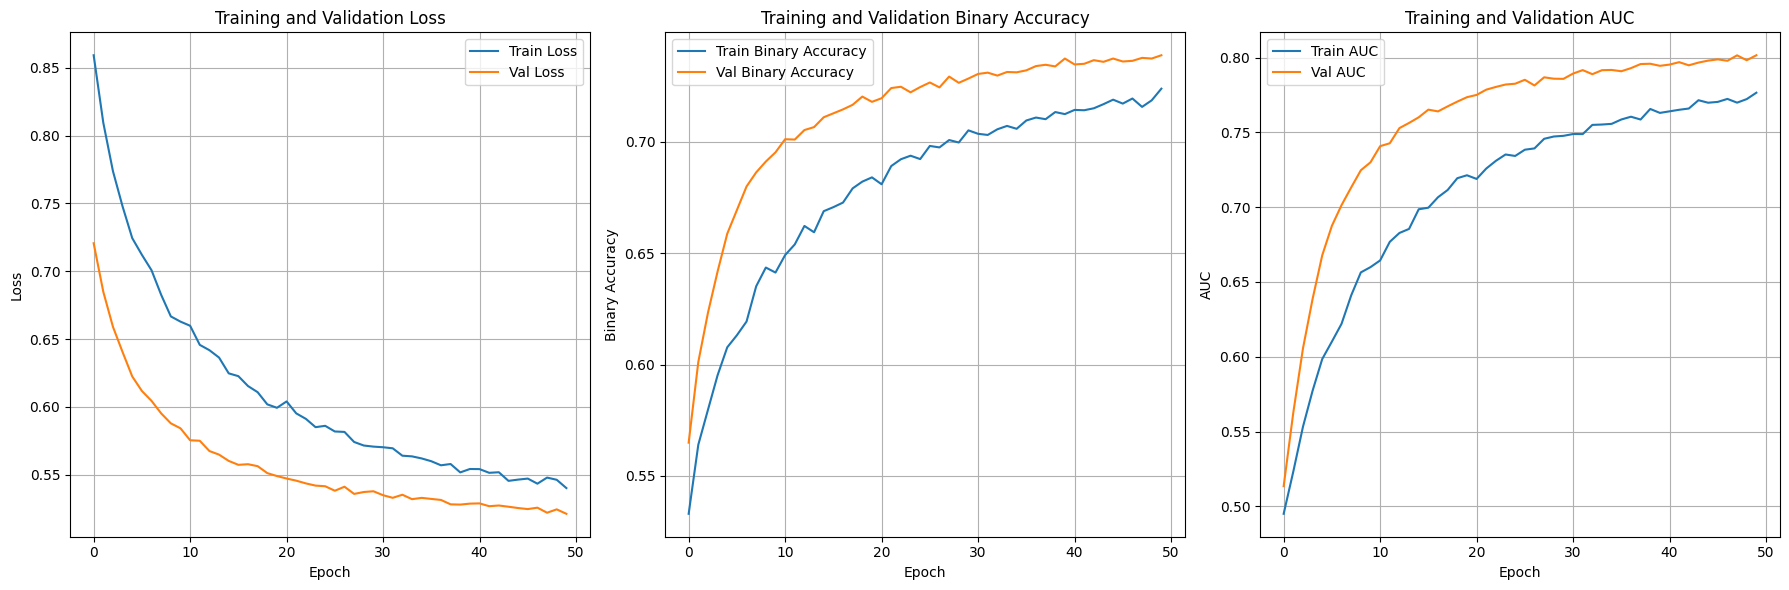

In [8]:
# --- 13. Visualisasi Hasil Pelatihan ---
print("\n--- 13. Memvisualisasikan Hasil Pelatihan ---")
plt.figure(figsize=(18, 6)) # Ukuran figure diperbesar untuk 4 plot

# Plot Loss
plt.subplot(1, 3, 1) # Ubah menjadi 1 baris, 3 kolom
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['binary_accuracy'], label='Train Binary Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Val Binary Accuracy')
plt.title('Training and Validation Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

# Tambahan: Precision dan Recall biasanya lebih baik dihitung di luar pelatihan
# karena membutuhkan thresholding. Namun, Anda bisa memplot jika Keras menyediakannya
# secara langsung (tergantung versi TF)

plt.tight_layout()
plt.show()


Evaluasi Model pada Test Set

In [9]:
# --- 14. Evaluasi Model pada Test Set ---
print("\n--- 14. Mengevaluasi Model pada Test Set ---")
try:
    best_model = tf.keras.models.load_model(checkpoint_path)
    print("Model terbaik berhasil dimuat kembali.")
    # Evaluasi dengan metrik yang lebih detail
    evaluation_results = best_model.evaluate(X_test, y_test, verbose=1)
    
    # Map hasil evaluasi ke nama metrik
    metrics_names = best_model.metrics_names
    print("Evaluasi pada Test Set:")
    for name, value in zip(metrics_names, evaluation_results):
        print(f"- {name}: {value:.4f}")

except Exception as e:
    print(f"Gagal memuat model terbaik dari {checkpoint_path}: {e}")
    print("Mengevaluasi model terakhir yang dilatih (mungkin bukan yang terbaik).")
    evaluation_results = model.evaluate(X_test, y_test, verbose=1)
    
    metrics_names = model.metrics_names
    print("Evaluasi pada Test Set:")
    for name, value in zip(metrics_names, evaluation_results):
        print(f"- {name}: {value:.4f}")



--- 14. Mengevaluasi Model pada Test Set ---


Model terbaik berhasil dimuat kembali.
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 515ms/step - auc: 0.8069 - binary_accuracy: 0.7452 - loss: 0.5124 - precision: 0.7558 - recall: 0.4515
Evaluasi pada Test Set:
- loss: 0.5140
- compile_metrics: 0.7425


Contoh Prediksi dan Thresholding

In [10]:
# --- 15. Contoh Prediksi dan Thresholding (untuk Inferensi) ---
print("\n--- 15. Contoh Prediksi dan Thresholding ---")
# Ambil beberapa sampel dari test set untuk prediksi
num_samples_predict = 5
sample_indices = np.random.choice(len(X_test), num_samples_predict, replace=False)
X_sample = X_test[sample_indices]
y_true_sample = y_test[sample_indices]

# Lakukan prediksi dengan model terbaik (jika berhasil dimuat)
prediction_model = best_model if 'best_model' in locals() else model
y_pred_proba = prediction_model.predict(X_sample)

print("\nProbabilitas Prediksi (hasil Sigmoid):")
print(y_pred_proba)

# Terapkan threshold 0.5
threshold = 0.5
y_pred_thresholded = (y_pred_proba > threshold).astype(int)

print(f"\nPrediksi Setelah Thresholding (> {threshold}):")
print(y_pred_thresholded)

print("\nLabel Sebenarnya (True Labels):")
print(y_true_sample)

print("\nMembandingkan True vs Prediksi (contoh 5 sampel):")
for i in range(num_samples_predict):
    true_labels = [LABELS_FINAL[j] for j, val in enumerate(y_true_sample[i]) if val == 1]
    predicted_labels = [LABELS_FINAL[j] for j, val in enumerate(y_pred_thresholded[i]) if val == 1]
    
    print(f"\nSampel {i+1}:")
    print(f"  True Labels: {true_labels}")
    print(f"  Predicted Labels: {predicted_labels}")


print("\n--- Pelatihan Model Selesai ---")
print("Anda sekarang memiliki model yang dilatih dan dievaluasi dengan metrik multi-label yang lebih relevan.")
print("Langkah selanjutnya bisa berupa fine-tuning, eksperimen dengan hyperparameter, atau deployment.")


--- 15. Contoh Prediksi dan Thresholding ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

Probabilitas Prediksi (hasil Sigmoid):
[[0.04486413 0.01531558 0.32820836 0.08935101 0.52897465 0.11348309
  0.47171718 0.12326552]
 [0.3018602  0.40513718 0.8424283  0.09601977 0.29495496 0.11163418
  0.2413671  0.26304004]
 [0.00790163 0.6276485  0.74088174 0.2814283  0.4380932  0.21336702
  0.7139923  0.3071016 ]
 [0.14108919 0.5216994  0.21608625 0.43316814 0.21390639 0.0177521
  0.06639918 0.05677871]
 [0.01934045 0.99637747 0.18516746 0.02739208 0.19791241 0.0264355
  0.10436435 0.1419001 ]]

Prediksi Setelah Thresholding (> 0.5):
[[0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]]

Label Sebenarnya (True Labels):
[[0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0.]]

Membandingkan True vs Prediksi (contoh 5 sampel):

Sampel 1:
  True Labels: ['metal', 'plastic']
  Predicted